In [384]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

#from mpltools import special ##leon

class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1
        self.keytime=keytime # 2
        self.ttime=ttime # 3
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx
        self.hmd_ry=hmd_ry
        self.hmd_rz=hmd_rz

def read_data(file,rawdata):
    print("Reading %s"%file)
    seperator="\t"
    with open(file,"r") as fp:
        for line in fp:
            if line.startswith("Time"):
                continue
            l=line[:-1]
            f=l.split(seperator) 
            if(int(f[3])==1):
                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
            else: 
                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))
                
    return rawdata

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime
        
class posDataClass(object):
    def __init__(self,targetid,target_lon,target_lat,zeroTime,relativeTime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.zeroTime=zeroTime
        self.relativeTime = relativeTime

def process_time(raw_data):
    timeData={}
    filteredData=[a for a in raw_data if a.keypress==1]
    for i in range(len(filteredData)-1):
        if(filteredData[i+1].targetid!=filteredData[i].targetid):
            continue # when resuming back
        if((i <= len(filteredData)-3) and (filteredData[i-1].targetid==filteredData[i+2].targetid)):
            continue # when two same targets appear one after one
        deltaTime=filteredData[i+1].ttime-filteredData[i].ttime
        #print(deltaTime, filteredData[i].targetid)

        key1=str(int(filteredData[i].target_lat))
        key2=str(int(filteredData[i].target_lon))
        if(key1 in timeData)==False:
            timeData[key1]={}
        if(key2 in timeData[key1])==False:
            timeData[key1][key2]=[]
        
        timeData[key1][key2].append(TimeData(filteredData[i].targetid,filteredData[i].target_lon,filteredData[i].target_lat,deltaTime))
    timeData[str(0)][str(0)]=[]   
    timeData[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))
#    print(timeData['0'][str(180)])
        #print(key1, key2)
    return timeData

def track_head(raw_data):
    posData = {}
    zeroTime = 0
    currentTargetID = 0

    for i in range(len(raw_data)):
        if (raw_data[i].keypress == 1 and raw_data[i].targetid != currentTargetID):
            zeroTime = raw_data[i].ttime
            currentTargetID = raw_data[i].targetid
        continue
        relativeTime = raw_data[i].ttime - zeroTime
        
        key1=str(int(filteredData[i].target_lat))
        key2=str(int(filteredData[i].target_lon))
        key3=str(zeroTime)
        if(key1 in timeData)==False:
            posData[key1]={}
        if(key2 in timeData[key1])==False:
            posData[key1][key2]={}
        if(key3 in timeData[key1][key2])==False:
            posData[key1][key2][key3]=[]
        
        posData[key1][key2].append(posDataClass(raw_data[i].targetid,raw_data[i].target_lon,raw_data[i].target_lat, zeroTime, relativeTime))
        
    return posData

def plotTrial(raw_data,fig,raw,col,idx):
    #fig = plt.figure()
    ax = fig.add_subplot(raw,col,idx)
    for i in range(13):
        tx=[a.tx for a in raw_data if a.keypress==1]
        ty=[a.ty for a in raw_data if a.fittstrial==trial and a.tid==i]
        x=[a.x for a in raw_data if a.fittstrial==trial and a.tid==i]
        y=[a.y for a in raw_data if a.fittstrial==trial and a.tid==i]
        z=[a.z for a in raw_data if a.fittstrial==trial and a.tid==i]


        mpl.rcParams['legend.fontsize'] = 7

        ax.scatter(tx,ty)
        ax.plot(x, y, label='tid:'+str(i))
    #ax.legend()


def read_plot(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    #key1=['-30','0','30']
    key1=['0','0','0']
    key2=[30,60,90,120,150,180]
    #return timeData


    means=[]
    stddev=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            #if(k1==1 and k2==0):
            #if(k2==0):
            #    m1.append(0)
            #    s1.append(0)
            #    continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            mean=np.mean(data)
            std=np.std(data)
            
            m1.append(mean)
            s1.append(std)
        means.append(m1)
        stddev.append(s1)        
    return means

def read_plot2(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    

    key1=['-30','0','30']
    if (len(timeData) == 1):
        key1=['0']
    #key1=['0']
    key2=[0,30,60,90,120,150,180]
    #return timeData

    
    means=[]
    stddev=[]
    overall=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            overall.extend(data)
            mean=np.mean(data)
            std=np.std(data)
            
            m1.append(mean)
            s1.append(std)
            
        means.append(m1)
        stddev.append(s1)
    overallMean = np.mean(overall)
    
    
    #if (len(timeData) == 3):
    #    m1=[]
    #    s1=[]
    #    data=[]
    #
     #   for k2 in range(len(key2)):

      #      data.extend([a.deltatime for a in timeData[key1[0]][str(key2[k2])]])
    #     data.extend([a.deltatime for a in timeData[key1[1]][str(key2[k2])]])
     #       data.extend([a.deltatime for a in timeData[key1[2]][str(key2[k2])]])

     #       mean=np.mean(data)
      #      std=np.std(data)
            
       #     m1.append(mean)
        #    s1.append(std)
        
    #print (means) 
    #means.append(m1)
    #stddev.append(s1)
    #print (means) 

    return means,overallMean


def read_plot3(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    

    key1=['-30','0','30']
    if (len(timeData) == 1):
        key1=['0']
        print("only one")
    #key1=['0']
    key2=[0,30,60,90,120,150,180]
    #return timeData

    
    means=[]
    stddev=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            #angle = math.degrees(math.acos(math.cos(math.radians(30*k1-30)) * math.cos(math.radians(30*k2)))) #k1
            angle = math.sqrt( (30*k1-30)*(30*k1-30) + (30*k2)*(30*k2) ) # for 1,2 approximately
            #angle = 30*k2 # for condition 3,4,5 only
            speed=[]
            #print(str(data))
            
            for i in range(len(data)):
            #    print(str(angle),str(data[i]))
                if (data[i] == 0):
                    speed.append(0)
                    continue
                speed.append(angle / data[i])
                
            #np.true_divide(angle, data)
            mean=np.mean(speed)
            std=np.std(speed)
            
            m1.append(mean)
            s1.append(std)
            
        means.append(m1)
        stddev.append(s1)
    
    if (len(timeData) == 3):
        r=[]
        for j in range(len(means[0])):
            if(means[1][j]==0):
                #r.append(0) # speed = 0
                r.append( (means[0][j] + means[2][j]) / 2 )
                continue
            r.append( (means[0][j] + means[1][j] + means[2][j]) / 3 ) 
        means.append(r)

        #print (means) 
        #means.append(m1)
        #stddev.append(s1)
        #print (means) 

    return means,stddev


def make_ratio(mean_before, mean_after):
    
    ratio=[]
    log=[]
    
    for i in range(len(mean_before)):
        r=[]
        l=[]
        for j in range(len(mean_before[i])):
            if(mean_after[i][j]==0):
                #r.append(1) #ratio
                #l.append(0) #log
                continue
            r.append(mean_before[i][j]/mean_after[i][j]) #ratio
            l.append(-math.log2(mean_before[i][j]/mean_after[i][j])) #log
            #print(i,j,mean_after[i][j],mean_before[i][j])
        ratio.append(r)
        log.append(l)
        
    return ratio,log

def make_ratio_r(mean_before, mean_after):
    
    ratio=[]
    log=[]
    
    for i in range(len(mean_before)):
        r=[]
        l=[]
        for j in range(len(mean_before[i])):
            if(mean_after[i][j]==0):
                #r.append(1) #ratio
                #l.append(0) #log
                continue
            r.append(mean_after[i][j]/mean_before[i][j]) #ratio
            l.append(-math.log2(mean_before[i][j]/mean_after[i][j])) #log
            #print(i,j,mean_after[i][j],mean_before[i][j])
        ratio.append(r)
        log.append(l)
        
    return ratio,log

def make_speed(time):
    
    key1=[-30, 0, 30]
    key2=[0,30,60,90,120,150,180]
    
    speed=[]
    
    for i in range(len(time)-1):
        r=[]
        for j in range(len(time[i])):
            
            if(time[i][j]==0):
                #r.append(0) # speed = 0
                r.append(0)
                continue
            #r.append( (math.sqrt(key1[i] * key1[i] + key2[j] * key2[j])) / mean[i][j] )
            
            r.append( math.degrees(math.acos(math.cos(math.radians(key1[i])) * math.cos(math.radians(key2[j])))) / time[i][j] )
            #print(
        speed.append(r)
    #print("speed0" + str(speed))
    
    if (len(time) == 3):
        r=[]
        for j in range(len(time[1])):
            if(time[1][j]==0):
                #r.append(0) # speed = 0
                r.append( (speed[0][j] + speed[2][j]) / 2 )
                continue
            r.append( (speed[0][j] + speed[1][j] + speed[2][j]) / 3 ) 
        speed.append(r)
    
    #print("speed1" + str(speed))
        
    return speed

def plotbar(r,s=None):
    
    plt.figure(1, figsize = (9,16))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(7)
    width = 0.2
    offset = 0.4
    ax = plt.gca()
    
    plt.bar(x-offset,r[0], width, label="-30", color="C0")
    plt.bar(x,r[1], width, label="0", color="C1")
    plt.bar(x+offset,r[2], width, label="30", color="C2")

    ax.set_xlabel('Group')
    ax.set_ylabel('Scores')
    
    ax.legend()
    plt.xticks(x,key2)
    plt.show()
    
def plotcontrast(r1,r2,r3,s1,s2,s3):

    plt.figure(1, figsize = (12,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(7)
    width = 0.2
    offset = 0.4
    opacity = 0.2
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    plt.bar(x-offset*0.5,r1, width, label="-30", color="C0", alpha=1-opacity, yerr=s1)
    plt.bar(x,r2, width, label="0", color="C0", alpha=1-2*opacity, yerr=s2)
    plt.bar(x+offset*0.5,r3, width, label="30", color="C0", alpha=1-3*opacity, yerr=s3)

    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Speed')
    
    ax.legend(title="Latitude", loc = 2)
    plt.ylim(0,100) # speed
    plt.xticks(x,key2)
    
    plt.show()
    
    
def plotcontrast2(r,s):
    
    r=np.array(r)
    s=np.array(s)

    plt.figure(1, figsize = (12,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(3)
    width = 0.1
    offset = 0.1
    opacity = 0.1
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    plt.bar(x-3*offset, r.T[0], width, label="0", color="C0", alpha=1-opacity, yerr=s.T[0])
    plt.bar(x-2*offset, r.T[1], width, label="30", color="C0", alpha=1-opacity*2, yerr=s.T[1])
    plt.bar(x-offset, r.T[2], width, label="60", color="C0", alpha=1-opacity*3, yerr=s.T[2])
    plt.bar(x       , r.T[3], width, label="90", color="C0", alpha=1-opacity*4, yerr=s.T[3])
    plt.bar(x+offset, r.T[4], width, label="120", color="C0", alpha=1-opacity*5, yerr=s.T[4])
    plt.bar(x+2*offset, r.T[5], width, label="150", color="C0", alpha=1-opacity*6, yerr=s.T[5])
    plt.bar(x+3*offset, r.T[6], width, label="180", color="C0", alpha=1-opacity*7, yerr=s.T[6])

    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Speed')
    
    ax.legend(title="Latitude", loc = 2)
    plt.ylim(0,100) # speed
    plt.xticks(x,key2)
    
    plt.show()
    
def plotcontrast3(r1,r2,s1,s2):
    
    r1=np.array(r1)
    s1=np.array(s1)
    r2=np.array(r2)
    s2=np.array(s2)

    plt.figure(1, figsize = (12,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(3)
    width = 0.05
    offset = 0.12
    opacity = 0.1
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    #for i in range(7):
    #    plt.bar(x+(i-3)*offset, r2.T[i], width, label=str(i*30), color="C3", alpha=1-opacity*i)
    #    plt.bar(x+(i-3)*offset, r1.T[i], width, label=str(i*30), color="C4", alpha=1-opacity*i)
        
    for i in range(7): 
        plt.bar(x+(i-3)*offset, r1.T[i], width, yerr=s1.T[i], label=str(i*30), color="C0", alpha=1-opacity*i)
        plt.bar(x+(i-3)*offset+width, r2.T[i], width, yerr=s2.T[i], label=str(i*30), color="C3", alpha=1-opacity*i)
        

    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Speed')
    
    ax.legend(title="Longitude", loc = 2)
    plt.ylim(0,100) # speed
    plt.xticks(x,key2)
    
    plt.show()
    
def plotcontrast4(r1,r2,s1,s2):
    
    print(np.array(r1).shape)
    print(np.array(r2).shape)
    print(np.array(s1).shape)
    print(np.array(s2).shape)
    
    r1=np.array(r1)
    s1=np.array(s1)
    r2=np.array(r2)
    s2=np.array(s2)
    
    
    lonMean1=[]
    lonMean2=[]
    latMean1=[]
    latMean2=[]
    
    lonStd1=[]
    lonStd2=[]
    latStd1=[]
    latStd2=[]
    
    for i in range(3):
        latMean1.append(np.mean(r1[i]))
        latStd1.append(np.std(r1[i]))
        latMean2.append(np.mean(r2[i]))
        latStd2.append(np.std(r2[i]))
        
    
    for i in range(7):
        lonMean1.append(np.mean(r1.T[i]))
        lonStd1.append(np.std(r1.T[i]))
        lonMean2.append(np.mean(r2.T[i]))
        lonStd2.append(np.std(r2.T[i]))
        

    plt.figure(1, figsize = (12,32))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    
    plt.subplot(4, 1, 1)
    x = np.arange(7)
    width = 0.1
    offset = 0.1
    opacity = 0.2
  
    #for i in range(7):
    plt.bar(x-3*offset,r1[0], width, label="-30(N)", color="C0", alpha=1-opacity, yerr=s1[0])
    plt.bar(x-2*offset,r2[0], width, label="-30(A)", color="C3", alpha=1-opacity, yerr=s2[0])
    plt.bar(x-0.5*offset,r1[1], width, label="0(N)", color="C0", alpha=1-2*opacity, yerr=s1[1])
    plt.bar(x+0.5*offset,r2[1], width, label="0(A)", color="C3", alpha=1-2*opacity, yerr=s2[1])
    plt.bar(x+2*offset,r1[2], width, label="30(N)", color="C0", alpha=1-3*opacity, yerr=s1[2])
    plt.bar(x+3*offset,r2[2], width, label="30(A)", color="C3", alpha=1-3*opacity, yerr=s2[2])
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Longitude", loc=2)
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Time')
    plt.ylim(0,10)
    plt.xticks(x,key2)
    
    
    
    plt.subplot(4, 1, 2)
     
    plt.bar(x-offset,lonMean1, 2*width, label="N", color="C0", alpha=1-opacity, yerr=lonStd1)
    plt.bar(x+offset,lonMean2, 2*width, label="A", color="C3", alpha=1-opacity, yerr=lonStd2)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Condition", loc=2)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Time')
    plt.ylim(0,10)
    plt.xticks(x,key2)
    
    
    
    plt.subplot(4, 1, 3)
    
    x = np.arange(3)
    width = 0.05
    gap = 0.02
    opacity = 0.1
    
    for i in range(7):
        plt.bar(x+(i-3)*(gap+2*width)-0.5*width,r1.T[i], width, label=str(30*i), color="C0", alpha=1-opacity*i, yerr=s1.T[i])
        plt.bar(x+(i-3)*(gap+2*width)+0.5*width,r2.T[i], width, label=str(30*i), color="C3", alpha=1-opacity*i, yerr=s2.T[i])
        
       # width,width,gap,width,width,gap,width,width,gap,width|width,gap,width,width,gap,width,width,gap,width,width
        #plt.bar(x+(i-3)*offset, r1.T[i], width, yerr=s1.T[i], label=str(i*30), color="C0", alpha=1-opacity*i)
        #plt.bar(x+(i-3)*offset+width, r2.T[i], width, yerr=s2.T[i], label=str(i*30), color="C3", alpha=1-opacity*i)
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Time')
    ax.legend(title="Longitude")
    plt.ylim(0,10)
    plt.xticks(x,key1)
    
    
    
    plt.subplot(4, 1, 4)
    
    plt.bar(x-1.5*width,latMean1, 3*width, label='N', color="C0", alpha=1-opacity, yerr=latStd1)
    plt.bar(x+1.5*width,latMean2, 3*width, label='A', color="C3", alpha=1-opacity, yerr=latStd2)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel('Time')
    ax.legend(title="Condition")
    plt.ylim(0,10)
    plt.xticks(x,key1)
    
    
    
    plt.show()
    

def plotOverall(t1,t2):
    
    overallMean1= np.mean(t1)
    overallStd1= np.std(t1)
    
    overallMean2= np.mean(t2)
    overallStd2= np.std(t2)
    
    plt.figure(1, figsize = (12,16))
    key1=['','']
    key2=[1,2,3,4,5,9,10,14,6,13,8,12,11,7]
    
    x = np.arange(2)
    width = 0.5
    opacity = 0.1
    
    
    plt.subplot(2, 1, 1)
    plt.bar(x[0], overallMean1, yerr=overallStd1, label="Natural", color="C0", alpha=1-opacity)
    plt.bar(x[1], overallMean2, yerr=overallStd2, label="Augmented", color="C1", alpha=1-opacity)
    plt.xlabel('Overall')
    plt.ylabel('Response Time')
    
    plt.legend(title="Condition")
    plt.ylim(0,5) # time
    plt.xticks(x,key1)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    
    
    x = np.arange(len(t1))
    width = 0.3
    offset = 0.3
    opacity = 0.1
    
    plt.subplot(2, 1, 2)
    plt.grid(True, axis='y')
    
    plt.bar(x-offset*0.5, t1, width, yerr=0, label="Natural", color="C0", alpha=1-opacity)
    plt.bar(x+offset*0.5, t2, width, yerr=0, label="Augmented", color="C1", alpha=1-opacity)
    plt.xlabel('Individual Users')
    plt.ylabel('Reponse Time')
    plt.legend(title="Condition")
    
    #ax.legend(title="Latitude", loc = 2)
    plt.ylim(0,5) # time
    plt.xticks(x,key2)
    
    ax = plt.gca()
    ax.set_axisbelow(True)
    
    plt.show()   
    

def plotratio(r,s=None):
    plt.figure(1, figsize = (8,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    xmean=[]
    for i in range(7):

        if (i==0):
            xmean.append( (r[0][0] + r[2][0]) / 2)
        else:
            xmean.append( (r[0][i] + r[1][i-1] + r[2][i]) / 3)
                              
    
    if(s!=None):
        print(r[1],s[1],key2)
        #ar1 = np.array(r[1])
        #as1 = np.array(s[1])
        #print(ar1,as1)
        ymax=[[],[],[]]
        ymin=[[],[],[]]
        
        for j in range(3):
            #ymax[j] = []
            for i in range(6):
                ymax[j].append(r[j][i] + s[j][i])
                ymin[j].append(r[j][i] - s[j][i])
                xmean[j].append((r[0][i] + r[1][i] + r[2][i]) / 3)
            xmean[j][0] = (r[0][0] + r[2][0]) / 2                    
        #color='crimson', color="limegreen" color='C0'
        
###################### plot 3 latitude, with error/standard deviation  (old, bar)
        #plt.errorbar(key2, r[2], label="30", yerr=s[2], fmt='-x',color='crimson',markersize=10,elinewidth=0.5,capsize=10,capthick=0.5)
        #plt.errorbar(key2, r[1], label="0", yerr=s[1], linewidth=2, fmt = '-x',markersize=10, elinewidth=1,capsize=5,capthick=0.5)
        #plt.errorbar(key2, r[0], label="-30", yerr=s[0], fmt=':v',markersize=10,elinewidth=2,capsize=10,capthick=0.5)

        #ax.errorbar(key2, r[0], label="-30-2",yerr=s[0], linestyle='dotted')       
        #ax.fill_between(key2, np.array(r[1]-s[1]),np.array(r[1]+s[1]), facecolor='blue', alpha=0.5)
        #plt.fill_betweenx(key2,r[1]-s[1], r[1]+s[1])
        
###################### plot 3 latitude, with error/standard deviation (new, area/shade)   
        #plt.fill_between(np.array(key2), ymin[0], ymax[0],alpha=0.2, label="-30")
        #plt.fill_between(np.array(key2), ymin[1], ymax[1],alpha=0.2, label="0")
        #plt.fill_between(np.array(key2), ymin[2], ymax[2],alpha=0.2, label="30")
        plt.plot(key2, r[0], ':v', label="-30")
        plt.plot(key3, r[1], '-o', label="0")
        plt.plot(key2, r[2], ':^', label="30")
        
###################### plot single latitude
        #pltid = 0;
        ##plt.fill_between(np.array(key2), ymin[pltid], ymax[pltid],alpha=0.2, label=key1[pltid],color='C'+ str(pltid))
        ##plt.plot(key2, r[pltid], '-x', markersize=10, label=key1[pltid],color='C'+ str(pltid), linewidth =2)
        #plt.plot(key2, xmean[1], '-x', markersize=10, label='all', color='black', linewidth =2) #combine all latitude
######################
    else:
        plt.plot(key2, xmean, '-', label="mean", linewidth=5, alpha=0.5)
        plt.plot(key2, r[0], '-v', label="-30") 
        plt.plot(key3, r[1], '-o', label="0")
        plt.plot(key2, r[2], '-^', label="30")
        
    
#    special.errorfill(key2, means1[0], y_err=stddev1[0], label='sin', label_fill='sin error')
#    special.errorfill(x, y_cos, y_err, label='cos', label_fill='cos error',alpha_fill=0.1)
#    plt.fill_between(key2, means1[2]-stddev1[2], means1[2]+stddev1[2])
###################### set figure scale
    #plt.axhline(y=0,linewidth=1, color='r') #log
    #plt.axhline(y=1,linewidth=1, color='r') #ratio
    plt.xticks(key2)
    plt.ylim(-1,2) #log
    #plt.ylim(0,100) # speed
    plt.xlim(-10)    
    #plt.rcParams["axes.grid.axis"] ="y"
    #plt.rcParams["axes.grid"] = True
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    plt.legend(title="Latitude")
    plt.ylabel('ratio')
    #plt.ylabel('log')
    plt.xlabel('Target Longitude')

    plt.savefig('user'+str(users[uid])+'.pdf')
    plt.show()
    


Reading ../Users/1/1.txt
Reading ../Users/1/2.txt
Reading ../Users/1/1.txt
Reading ../Users/1/2.txt
ratio
(4,)
[[1.19091594967251, 0.8944142729705576, 0.9649564406584332, 0.9905456238882586, 0.9802200534333573, 0.9235772692934785, 1.0107049436553168], [0.896462366419908, 0.9766153107697332, 1.090266542961106, 1.1295169133388037, 0.8412600166012943, 1.0871489948431172], [0.9082107297189415, 0.9877166284830851, 0.9630430758742023, 0.9176828976701975, 0.9787972630813598, 1.0016203105848303, 0.7677639115840409], [1.0339511975670708, 0.9254619387170689, 0.9683802772158815, 1.0032270403004515, 1.0323011380967813, 0.9140267002576905, 0.9562132808172225]]
[[1.1814301647220524, 0.8910697271546186, 0.9982399913086071, 1.0049169823935904, 0.9364290804680923, 0.9165077170391162, 1.1218951207711418], [0.907748041225529, 0.7773985865040022, 1.1108351331893707, 1.154978525663594, 0.8495933388714055, 1.1271659896048631], [0.8753006181304686, 0.989393843525541, 0.9622450966077859, 0.9147072208737824, 0

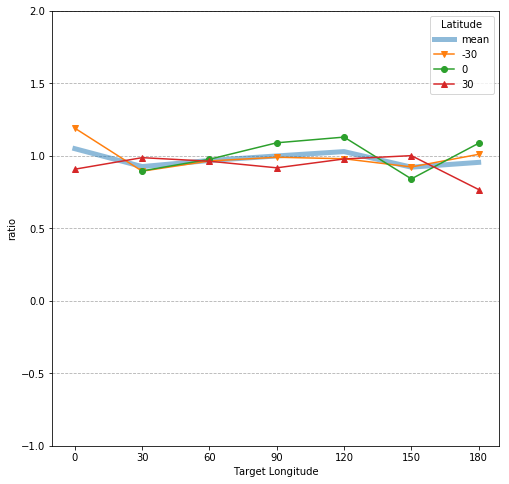

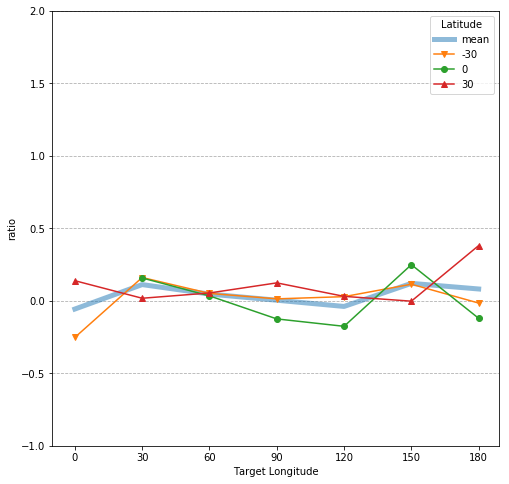

Reading ../Users/2/1.txt
Reading ../Users/2/2.txt
Reading ../Users/2/1.txt
Reading ../Users/2/2.txt
ratio
(4,)
[[0.8199282328083003, 0.7980660486755122, 1.0602128126972359, 0.8361892982514887, 1.0959849904358463, 0.7148675464666949, 0.6949890127010044], [0.878141821174531, 0.9950390509670174, 0.6529700640275099, 0.6643424019652653, 0.7068183053901927, 0.6299082463182001], [0.8853361948245145, 0.7297288895581978, 0.7512668243047461, 0.6397307102424025, 0.5206652724274289, 0.6447736588896461, 0.6880024169028887], [0.8497814918047931, 0.799308972368865, 0.9344044761361366, 0.710559785740789, 0.7364826468677833, 0.6905622084649885, 0.6675903729745744]]
[[0.8145769399386196, 0.8132960522456654, 1.071133194422185, 0.868499807092729, 1.1308568872813494, 0.7307513336546279, 0.7068220447248817], [0.8702302542049895, 0.9953302201467632, 0.48536178505954014, 0.6596221249766655, 0.698800529303793, 0.6028222948894488], [0.8770148546144144, 0.7533358818924861, 0.7566185998406969, 0.712549262520978, 

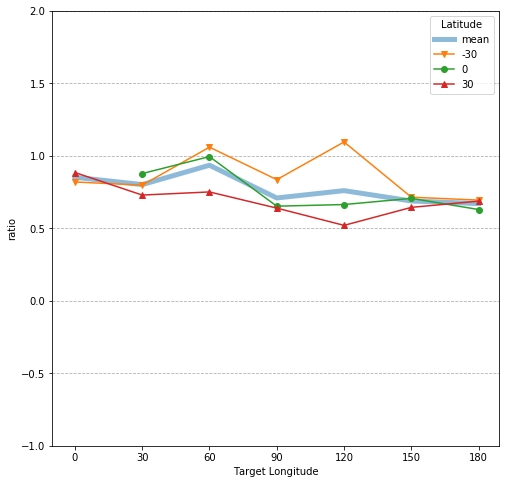

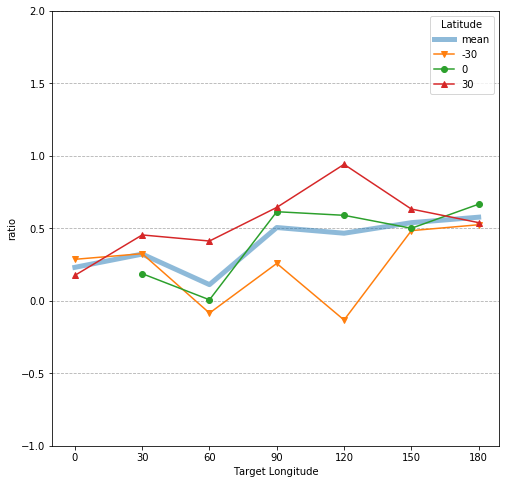

Reading ../Users/3/1.txt
Reading ../Users/3/2.txt
Reading ../Users/3/1.txt
Reading ../Users/3/2.txt
ratio
(4,)
[[0.9582792873309576, 0.77625955153341, 0.8990518151276258, 0.8547374119274951, 0.8415213883746083, 0.7841571406979917, 0.4848124155215666], [0.6695234060812318, 0.7474931415325591, 0.68612891152419, 0.9097528613208907, 0.6549552403935778, 0.5150025247791885], [0.893138798583795, 0.779124138820863, 0.9441747077131133, 0.90443333240262, 1.1576557526026743, 0.9006793885833673, 0.6318853912614385], [0.9235432867783907, 0.7425581979916719, 0.8506217851115735, 0.7933887021452628, 0.954120031574031, 0.765281531119598, 0.5393767733858074]]
[[0.9949704514019895, 0.7744397043802267, 0.9214177521963184, 0.8152846056961802, 0.8637829450218536, 0.7814437246127853, 0.4812883750030936], [0.6536261092871394, 0.7473942801965318, 0.6642909666836385, 0.9525025388074786, 0.6606116083536789, 0.47686656519533255], [0.9375383543694961, 0.7809383666308265, 0.9403462952215195, 1.0010914838067353, 1.4

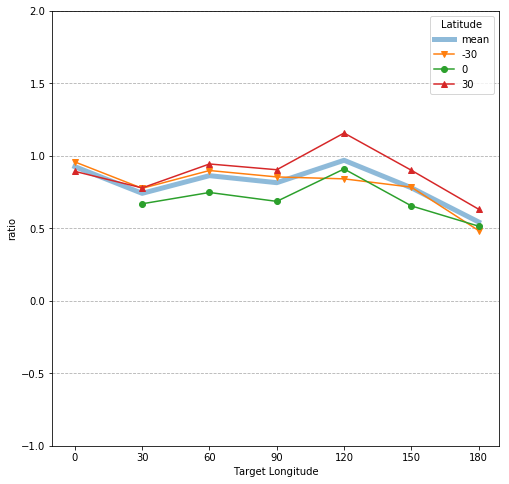

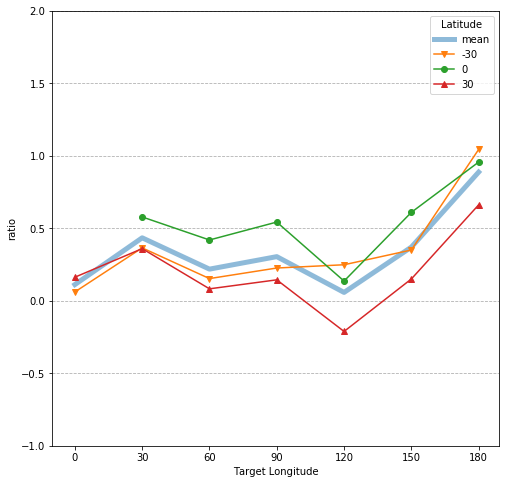

Reading ../Users/4/1.txt
Reading ../Users/4/2.txt
Reading ../Users/4/1.txt
Reading ../Users/4/2.txt
ratio
(4,)
[[0.9620273846466753, 0.9949052847076516, 1.1684096881842014, 0.9866899177090136, 1.0003102675710724, 0.7984089717362789, 0.7315983380238841], [1.0292769275263307, 0.8809555105785941, 0.9739896734207028, 0.8126354568589258, 0.6922229879319232, 0.5663921995595113], [0.9861877017269929, 0.9962324642696635, 0.8735498171268992, 0.9426026294434365, 0.7519848916497089, 0.7374811823865276, 0.7429701524162542], [0.9738401760610756, 1.0079363758263504, 0.9623621065136562, 0.968243440002782, 0.8471643743389906, 0.7389898707949557, 0.6644949713533381]]
[[0.9481937832540074, 1.106346334125436, 1.3277155017851219, 1.323526070657725, 0.9976295066159317, 0.7506607709826092, 0.8401543858890405], [0.9976037405026336, 0.872607982504108, 0.947238721091848, 0.8292893624115459, 0.6991847764379935, 0.6585506626763573], [0.9892292839145264, 1.0034877683779526, 0.6680718475073364, 0.937604362346081, 

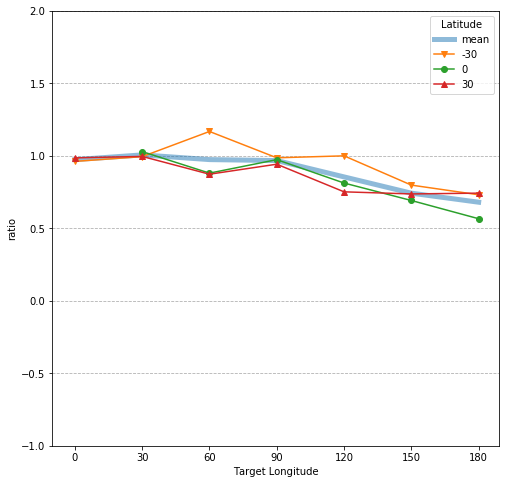

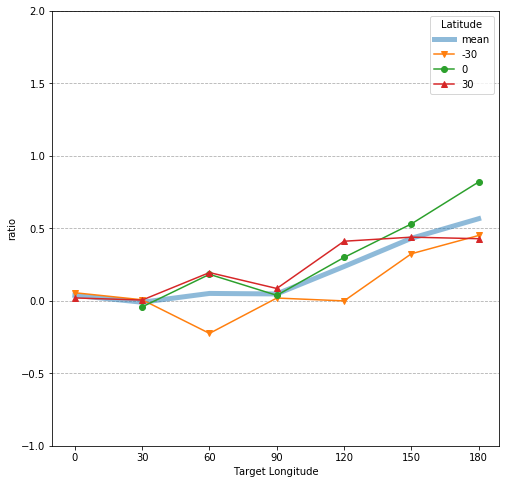

Reading ../Users/5/1.txt
Reading ../Users/5/2.txt
Reading ../Users/5/1.txt
Reading ../Users/5/2.txt
ratio
(4,)
[[1.1011057800238442, 0.7255408580982511, 0.9466083669902071, 0.95514487366914, 0.7833471416560929, 0.8134772879117445, 0.8760311822063098], [1.035182477569034, 1.0751762527257773, 0.8621746761377055, 0.6974306126714316, 0.6554065098442049, 0.6775090436153951], [0.9393171793837523, 1.068406040713821, 1.0139724820499119, 0.8967493389178123, 0.8717693309803781, 0.7059160089016615, 0.6008851327825521], [1.0179229591851298, 0.9305123695359276, 1.012631293133714, 0.9002732208511647, 0.7779088804258427, 0.72097031102813, 0.7124099504506938]]
[[1.0703329517561806, 0.5569672909451017, 0.953272000971637, 0.9815902480005367, 0.740060587959206, 0.7592636529080424, 0.8026040552735721], [1.0384261080671242, 1.0444831221863262, 0.8627432011179211, 0.6789394997619468, 0.6792021086439609, 0.660945241618945], [0.866025559376724, 1.092625159021185, 1.021805178516309, 0.892810174549183, 0.918381

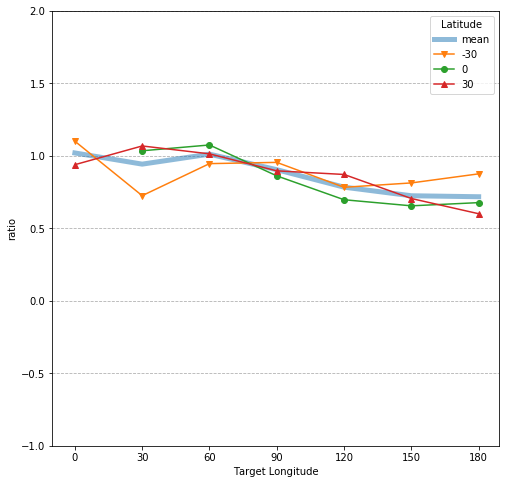

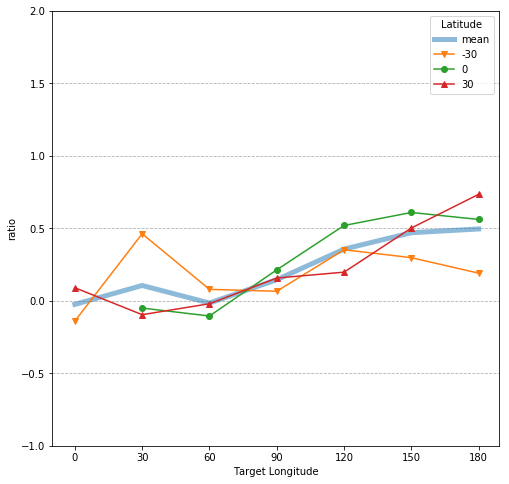

Reading ../Users/9/1.txt
Reading ../Users/9/2.txt
Reading ../Users/9/1.txt
Reading ../Users/9/2.txt
ratio
(4,)
[[0.8652106921710044, 0.7130184234848322, 1.012564088669038, 0.5594318513204702, 0.5172690429963241, 0.3657539050520437, 0.4197920032871705], [0.9503948442494431, 1.0042448688195895, 1.0609828721622117, 0.7178241297862752, 0.5704643399611984, 0.2781567469667276], [0.7205200066882559, 1.0033917525878058, 0.8550179060718062, 1.1604768445364404, 0.675235323339164, 0.611562842488819, 0.4345354766444066], [0.794600878755092, 0.8956551006313201, 0.9599859397023917, 0.9141371248781848, 0.6379228277946601, 0.5012710229605472, 0.3618933331451952]]
[[0.8271178339191696, 0.631120396970489, 0.9956982319164742, 0.5257923595066903, 0.4851946687676387, 0.33196893879495865, 0.41341532919131885], [1.025338001055445, 1.0334154211956512, 1.0363230434357413, 0.7184698976758875, 0.5611575853493033, 0.27687438249425783], [0.5875791387941458, 1.384399004652194, 1.1471510768552307, 1.7411966398080025

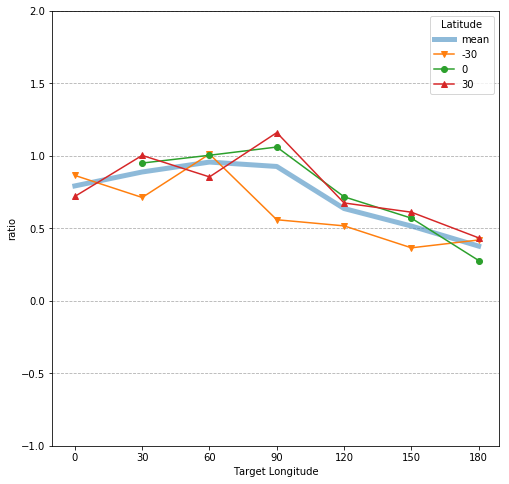

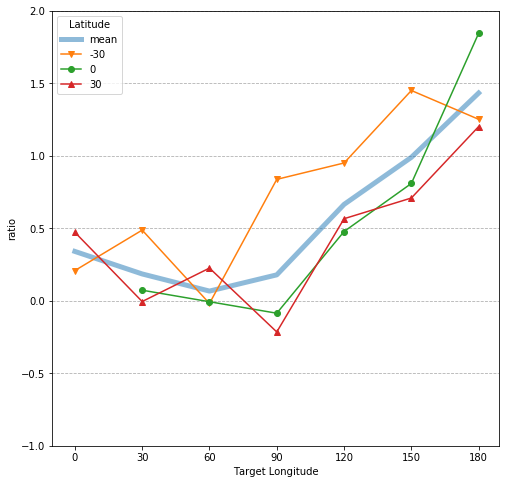

Reading ../Users/10/1.txt
Reading ../Users/10/2.txt
Reading ../Users/10/1.txt
Reading ../Users/10/2.txt
ratio
(4,)
[[1.3593156274536773, 1.446025246977763, 1.1975174550150627, 1.474576629056709, 1.1778727785118217, 1.1440743517820964, 0.9378332502287102], [1.566388709478441, 1.2345510061578804, 1.3383656013427532, 1.3576743720732591, 1.0888572873499431, 0.9263790022016185], [1.218257691362289, 1.25539005345802, 1.2133776284182984, 1.4751781280277445, 1.2127992897422823, 1.0396110453189003, 0.9448064486167702], [1.2888900141705761, 1.4155078350311598, 1.2162013926777004, 1.4249883255974827, 1.2511227267424525, 1.0878512378379153, 0.9361614986974139]]
[[1.3814424801913603, 1.464681082199575, 1.1735712316809934, 1.4607408898731753, 1.1245645096807346, 1.1127949662702268, 0.7747710109124605], [1.6205641012110907, 1.2428955909126875, 1.3456951300264801, 1.2834642919504178, 1.0400163475011692, 0.8170574055714311], [1.198817690727118, 1.2443242970536823, 1.2342514861954794, 1.5045092567383773

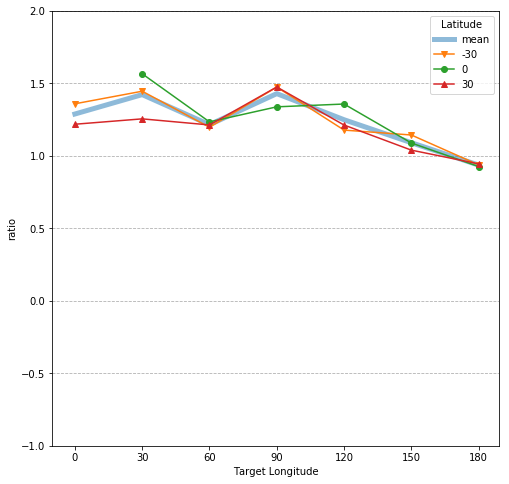

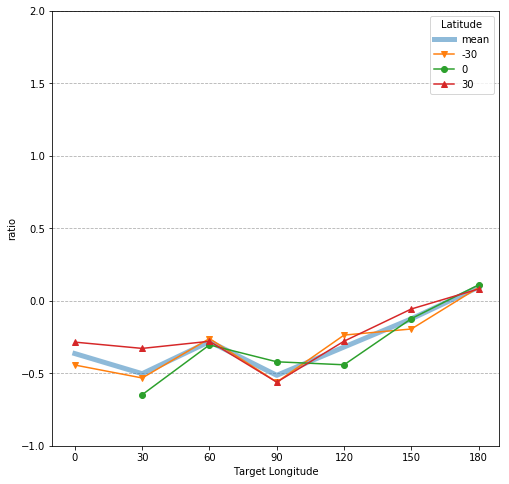

Reading ../Users/14/1.txt
Reading ../Users/14/2.txt
Reading ../Users/14/1.txt
Reading ../Users/14/2.txt
ratio
(4,)
[[1.1106275787120208, 0.8311674346322971, 0.9335367825083511, 0.9013194280397532, 0.8751116557689554, 0.7757334145615464, 0.7006871332406609], [1.0134951866429367, 1.1340883119288587, 0.9920550523643051, 0.7788365544499986, 0.7369222840811637, 0.6060858138499915], [1.1178121774843108, 0.9141034367819195, 0.8583093003631197, 0.9018926301221251, 0.7641796681957728, 0.7319223475252582, 0.6744382933934948], [1.114222318682762, 0.9163058005034901, 0.9888637857625553, 0.9344441709404706, 0.8033488793035407, 0.7481818933292126, 0.6548391365550795]]
[[1.1085381340106297, 0.8141161975446273, 0.9405549383962868, 0.9006490264603044, 0.8825131499615352, 0.6807509539080997, 0.659136111566087], [0.9994512278776511, 1.1403541717526584, 0.9924792570602087, 0.7804447306091519, 0.7322448675296066, 0.5959143615281131], [1.0898810959209297, 0.9148745519713416, 0.8734349171017521, 0.9277113642

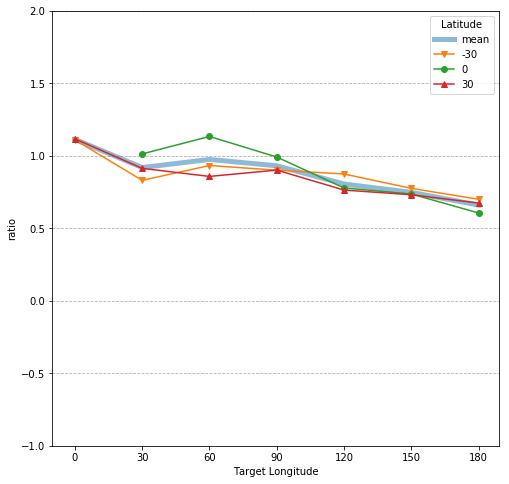

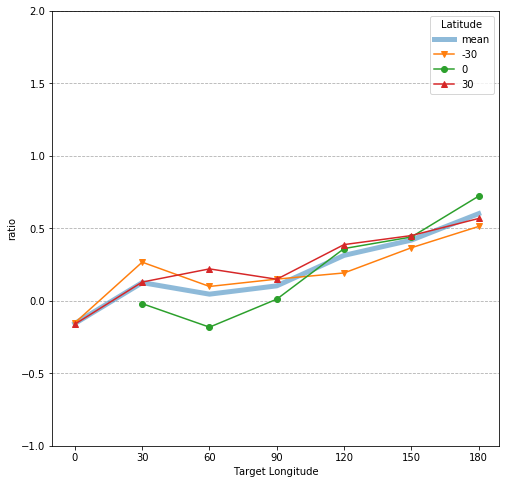

Reading ../Users/6/1.txt
Reading ../Users/6/2.txt
Reading ../Users/6/1.txt
Reading ../Users/6/2.txt
ratio
(4,)
[[0.7978233557711463, 1.43094963604249, 0.9177757012844917, 0.7166417884851468, 0.5340859083991807, 0.5694657777111193, 0.6706392216843495], [1.2413537013278078, 1.0556695328607142, 0.922477139168145, 1.0451109434160888, 0.7651687068385805, 0.9225990082873494], [0.7039851847061915, 0.8051823813518459, 0.9291946528278062, 0.9790013662517203, 0.6672465666465669, 0.8417719656820309, 0.7033253040083938], [0.747320817637189, 1.08747356649449, 0.9709982375344107, 0.860245944020542, 0.7080266971010258, 0.716817126680111, 0.7682645941552855]]
[[0.6145532164799383, 2.140497734717198, 0.9740239347682184, 0.7096928158231274, 0.5383974421083225, 0.6065905879688646, 0.6555249732896548], [1.2666464738250327, 1.12896218950245, 0.9218153780349057, 1.1207291239579038, 0.7519768631185392, 0.8993702389791808], [0.7141986955681933, 0.8365134849116422, 0.9591375631233878, 0.9674389208192604, 0.799

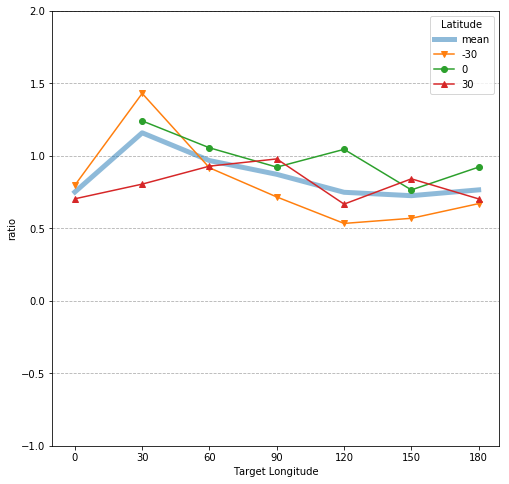

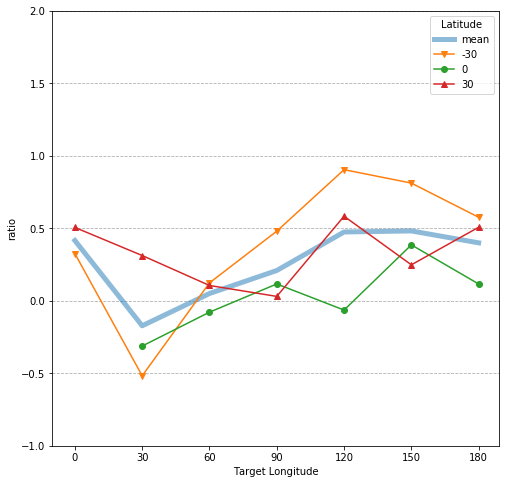

Reading ../Users/13/1.txt
Reading ../Users/13/2.txt
Reading ../Users/13/1.txt
Reading ../Users/13/2.txt
ratio
(4,)
[[0.5478839820862467, 0.5059029860495311, 0.4315308578909428, 0.5441420254939279, 0.4647511065773811, 0.3271758080634212, 0.3276282121052277], [0.4637832635260045, 0.8673361106532048, 0.4900679791102267, 0.466690517924579, 0.3462980227521879, 0.39422287362595776], [0.38460833088166835, 0.3528437802341401, 0.4640983105624676, 0.5023539432020305, 0.4543511742328558, 0.545166462034088, 0.5324337656225128], [0.46335437420516895, 0.44120496645387536, 0.5759442776147358, 0.5129930043706525, 0.46278120698616465, 0.38742750813995924, 0.4020848534726444]]
[[0.5191212476048497, 0.4897173811799921, 0.42148495839556377, 0.5360657116425144, 0.43915951837569844, 0.31736799085627343, 0.29383079025749215], [0.4569133062973396, 0.9537108562600027, 0.49462796814087384, 0.4320158352460576, 0.3180441603634177, 0.305485386336944], [0.367100465359906, 0.2786525359575991, 0.4712315064094629, 0.4

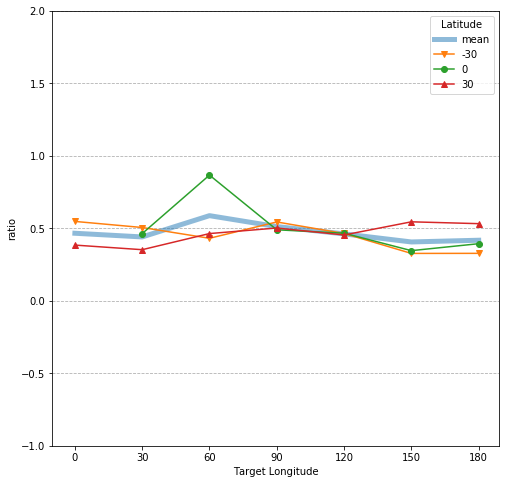

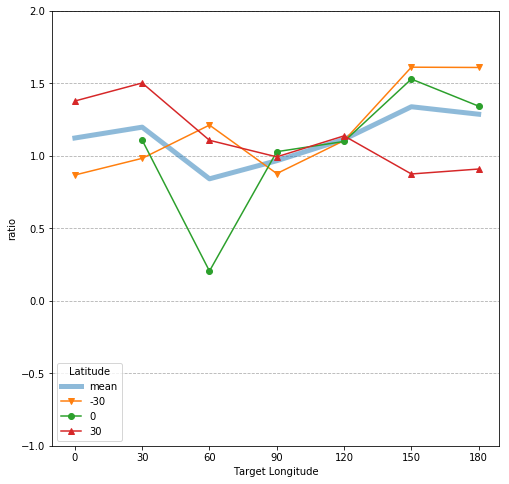

Reading ../Users/8/1.txt
Reading ../Users/8/2.txt
Reading ../Users/8/1.txt
Reading ../Users/8/2.txt
ratio
(4,)
[[1.0773045542759396, 0.7743167164480474, 1.0749394508414358, 1.2477962430984093, 1.1331117454984128, 1.0797624252267572, 0.35056627648864414], [1.0884523126745689, 1.4503755764437904, 1.5629575348629332, 0.9508195862941686, 0.659405074259985, 1.125829766801196], [1.2019637548866344, 0.8649455355110466, 0.9699240686516706, 0.7338245915465881, 0.8528864416847078, 0.9009007672921632, 1.2468650539322523], [1.1420688328104636, 0.8948493605609277, 1.1453983394990517, 1.1422958356184274, 0.9734016630959532, 0.8875537701416699, 0.8795019729330283]]
[[1.0778906386483218, 0.7479587366073194, 1.14626795984634, 1.2460946473696202, 1.1479658903232253, 1.0634062219769598, 0.3498626447616499], [1.0893362790553163, 1.4715416598153706, 1.678773430561402, 0.9463643547112632, 0.6044704093122566, 1.1230499240964273], [1.2024027733503277, 0.8685284858332489, 0.9106160141734962, 0.7290159140828194

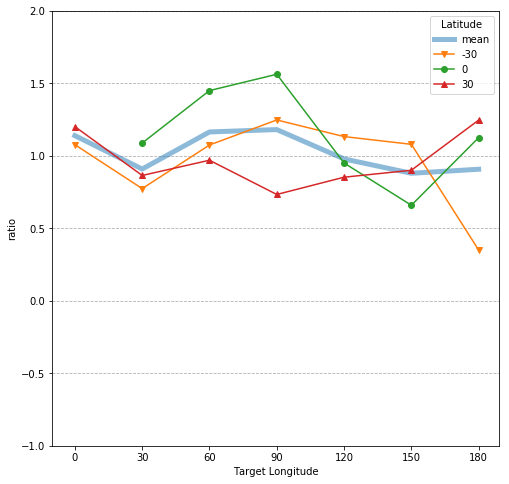

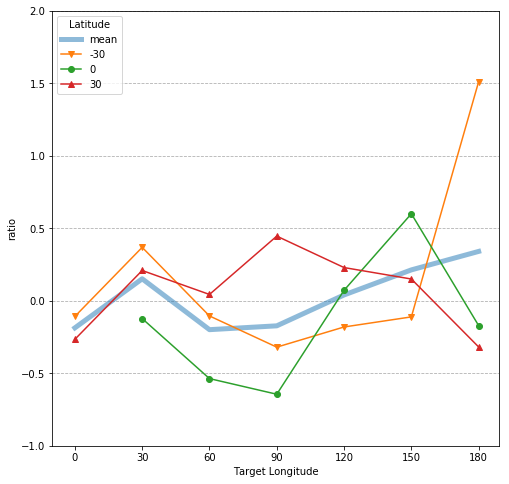

Reading ../Users/12/1.txt
Reading ../Users/12/2.txt
Reading ../Users/12/1.txt
Reading ../Users/12/2.txt
ratio
(4,)
[[0.6698957504080234, 0.9439952102454335, 0.8996888558893164, 0.9079080934143432, 0.8999913454311622, 0.8776858398563164, 1.052368199966766], [0.8442999050510149, 0.7242680665533131, 0.8566963226493048, 0.7746143582827514, 0.9061691590381308, 0.9656043911434702], [0.6301764229515483, 1.0037248436444879, 0.8284253301457164, 0.8148349338423941, 0.6556891395112623, 0.9551482498430461, 1.1170114170736087], [0.6501547214916363, 0.9317515389203318, 0.8167467255736637, 0.8586181587435863, 0.7769879146956464, 0.9096085259674815, 1.0385733517483395]]
[[0.6664935895996551, 0.9413028382952887, 0.9007522701134584, 0.9026073834432669, 0.9541404926712825, 0.8761962483799368, 1.0854532852199363], [0.7947513553935553, 0.7287225300214657, 0.8215681756788964, 0.7846199257843295, 0.9199708377204925, 0.9558175313954016], [0.2516202210287297, 0.9962379189509922, 0.8142458313627855, 0.735311753

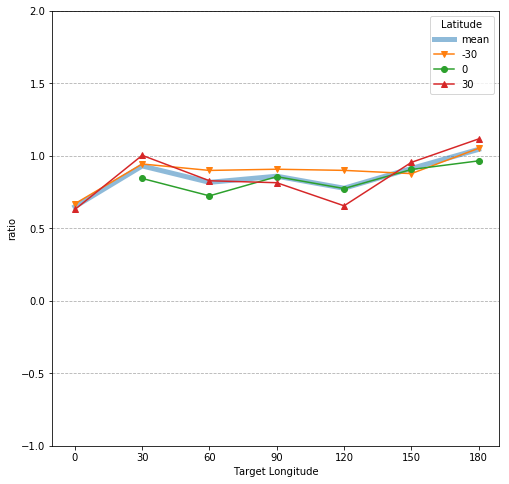

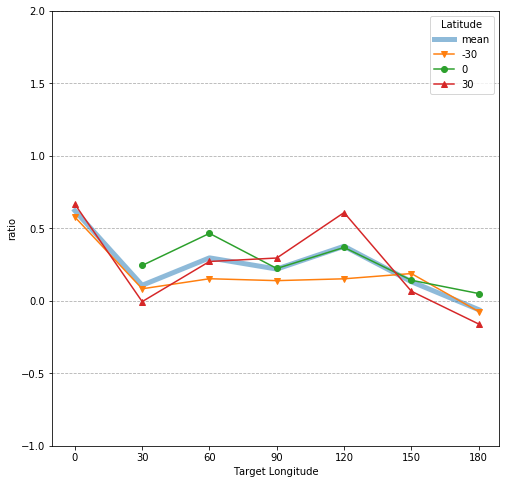

Reading ../Users/11/1.txt
Reading ../Users/11/2.txt
Reading ../Users/11/1.txt
Reading ../Users/11/2.txt
ratio
(4,)
[[0.4785625235161214, 0.9624947895421399, 2.211201320954094, 1.2491930057841274, 1.0228212565709514, 0.8466548642182341, 1.3271091616260347], [1.1619518494669892, 1.177697440048168, 1.3986306940023672, 1.133034076983827, 1.2883900708834495, 0.8134112770377129], [0.7435430193607221, 1.162134607475125, 1.4038970205937449, 0.977147355006127, 1.3770522296701948, 0.8045932866634078, 0.6489984223032613], [0.6164881659731826, 1.1122923102794502, 1.4534668850523091, 1.1851076768483746, 1.2015909834967737, 0.9899354462506076, 0.8924855881438934]]
[[0.24116359861785966, 0.8879177583551696, 2.3121628580624645, 1.2503976955157183, 0.9482578408116557, 0.8028875061571846, 1.3920034096796965], [1.2130142325124582, 1.1466909515204189, 1.4610361340879487, 1.2129463360729469, 1.1990393183676842, 0.8133973828552712], [0.6556618974857608, 1.0669308000540005, 1.1741951596486535, 1.077563065623

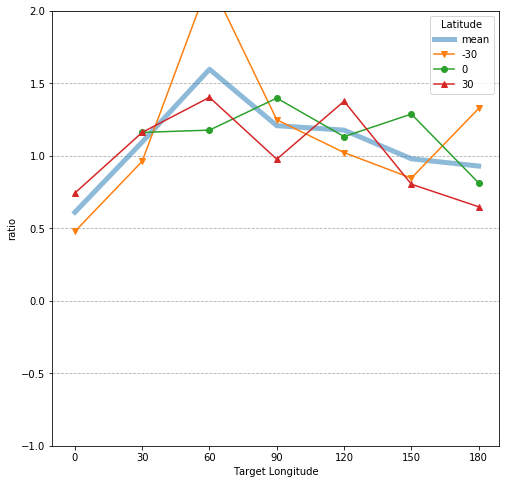

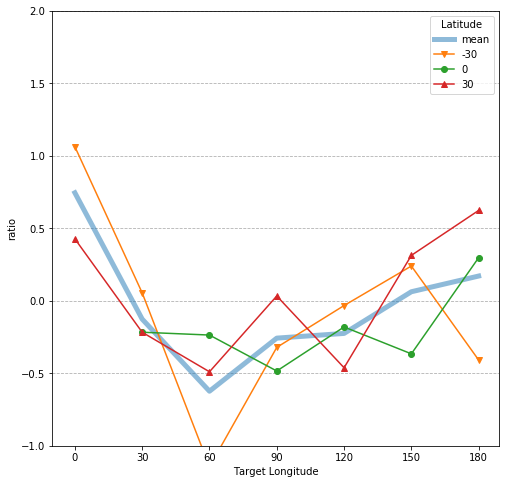

Reading ../Users/7/1.txt
Reading ../Users/7/2.txt
Reading ../Users/7/1.txt
Reading ../Users/7/2.txt
ratio
(4,)
[[0.9417885797187991, 0.2674292954488749, 1.0011540170244169, 1.130936843466658, 1.5302916753160074, 0.697322362601001, 0.3747222036613386], [0.9709539444714115, 1.0568596052472736, 0.7730885709927244, 0.7724496532156088, 0.8131432142412413, 0.23136105665016837], [0.8162404435170908, 2.06717486352987, 1.2137963749990617, 0.6254310158146905, 0.9060230804246305, 0.35940881726261314, 0.5547606665167507], [0.8779746774900713, 0.9456940484497899, 1.1125927132776414, 0.8094454173741651, 0.9586731915931462, 0.6125779232986157, 0.38402079060276634]]
[[0.9226835345984244, 0.267493666462829, 1.2306182185986687, 1.124741685087137, 2.077941012936645, 0.8230482607556919, 0.3805483756869983], [0.9678640687043881, 1.0346734782570186, 0.7732901348123411, 0.7423580786026184, 0.805994680630004, 0.2137194690515959], [0.8288458180548197, 2.597326255775083, 1.2120011630442649, 0.49554313340383743,

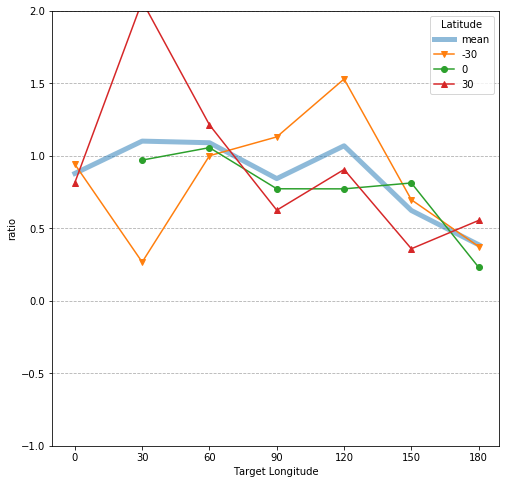

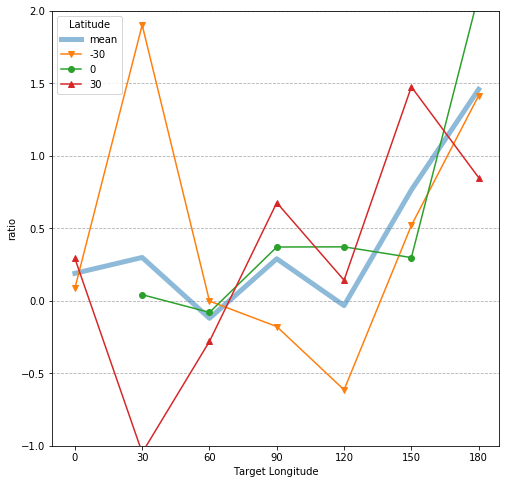

In [385]:
fig, ax = plt.subplots(figsize=(8,8))
groupSpeed1=[]
groupSpeed2=[]
groupSpeed3=[]
ratio=[[],[],[]]
overallTime1=[]
overallTime2=[]
groupTime1=[]
groupTime2=[]
###################### choose user
users=[1,2,3,4,5,9,10,14,6,13,8,12,11,7]
#users=[14,16,17,18,19,15]
######################

file = open("t-test.txt","w")

for uid in range(len(users)):
    baseFolder=str(users[uid])

    #idx=[3,4,5]
    idx=[1,2,3]

   # for i in range(len(idx)):
    #print("Trial 1"+str(i))
    mt1,ot1=read_plot2("../Users/"+baseFolder+"/"+str(idx[0])+".txt",1,fig)
    #print("Trial 2"+str(i))
    mt2,ot2=read_plot2("../Users/"+baseFolder+"/"+str(idx[1])+".txt",1,fig)
    #t3=read_plot2("../Users/"+baseFolder+"/"+str(idx[2])+".txt",1,fig)
    
    #s1 = make_speed(t1)
    #print(t1)
    #s2 = make_speed(t2)
    #s3 = make_speed(t3)
    r1,s1=make_ratio_r(mt1,mt2)
    #r2=make_ratio(t1,t3)
    #r3=make_ratio(t2,t3)
    
    overallTime1.append(ot1)
    overallTime2.append(ot2)
    groupTime1.append(mt1)
    groupTime2.append(mt2)
    
    ts1, tsdev1 = read_plot3("../Users/"+baseFolder+"/"+str(idx[0])+".txt",1,fig)
    ts2, tsdev2 = read_plot3("../Users/"+baseFolder+"/"+str(idx[1])+".txt",1,fig)
    #ts3, tsdev3 = read_plot3("../Users/"+baseFolder+"/"+str(idx[2])+".txt",1,fig)
    
    groupSpeed1.append(ts1)
    groupSpeed2.append(ts2)
    groupSpeed3.append(ts3)
    
    #print(np.array(ts1).shape)
    #print(str(ts1))
    #print(np.array(tsdev1).shape)

    ratio[0].append(s1[0])
    ratio[1].append(s2[0])
    ratio[2].append(s3[0])
    
    #plotbar(r1)
    #plotratio(r1)
    #plotcontrast(s1[0],s2[0],s3[0]) # angle cal is not correct
    
    if (len(idx)==3):    
        #plotcontrast(ts1[0],ts1[1],ts1[2],tsdev1[0],tsdev1[1],tsdev1[2])
        #plotcontrast(ts2[0],ts2[1],ts2[2],tsdev2[0],tsdev2[1],tsdev2[2])
        ratio1,log1 = make_ratio(ts1,ts2)
        
        print('ratio')
        print(np.array(ratio1).shape)
        print(str(ratio1))
        print(str(r1))
        plotratio(ratio1)
        plotratio(log1)

    #plotcontrast(s1[3],s2[3]) #all 3
    #plotratio(r3)
    
    file.write("A")
    file.write(str(users[uid]))
    file.write("\t")
    file.write(str(ot1))
    file.write("\t")
    file.write(str(ot2))
    file.write("\n")
    


(3, 7) (3, 7)
(3, 7)
(3, 7)
(3, 7)
(3, 7)


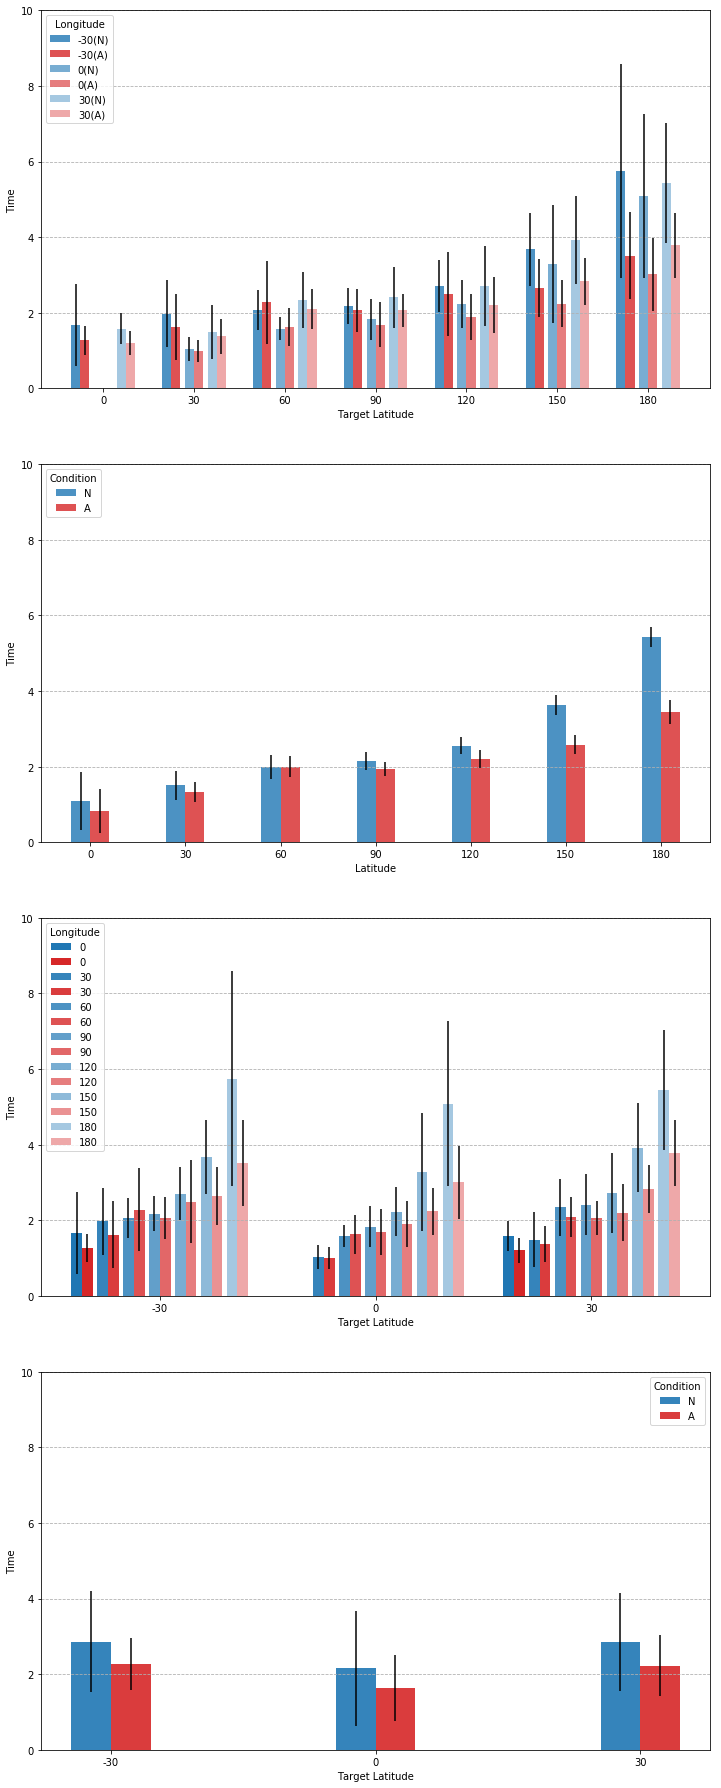

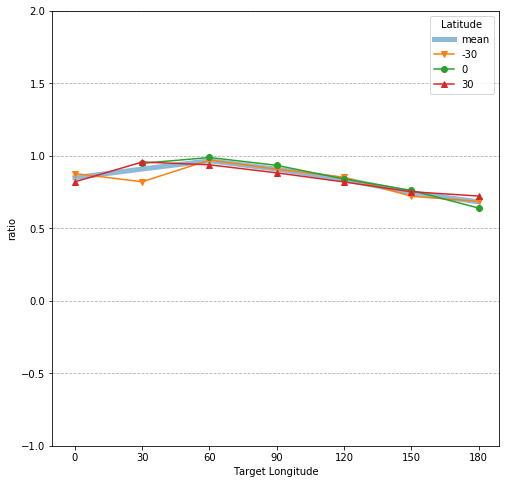

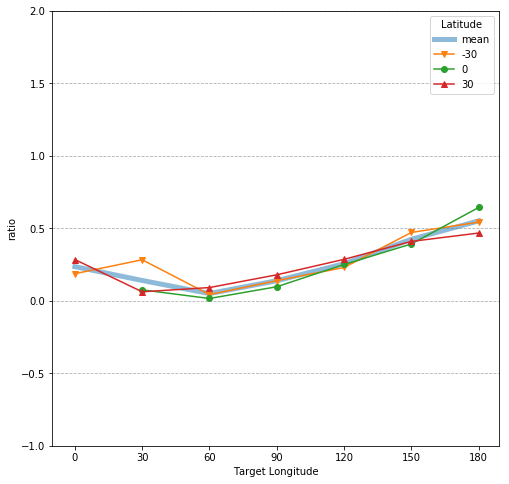

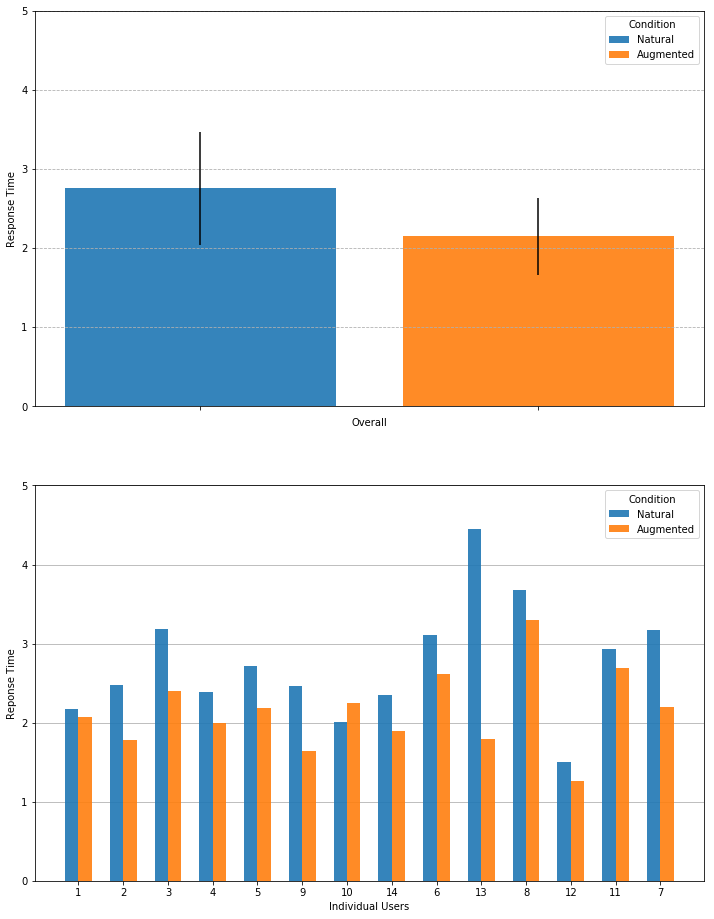

In [386]:
def calMean(data):

    meanR=[]
    stdR=[]
    
    #print(len(data[0]))
    
    for i in range(3): # 3 when all 3
        meanR.append([])
        stdR.append([])
        
        for j in range(7):
            r=[]
            
            if (i==1 and j==0):
                meanR[i].append(0)
                stdR[i].append(0)
                continue
            for k in range(len(data)):
                #print("i=" + str(i) + ",j=" + str(j) + ",k=" + str(k)) 
                r.append(data[k][i][j])
                #print("ok!")
            
            #print("RRR")
            #print(str(r))
            
            meanR[i].append(np.mean(r))
            stdR[i].append(np.std(r))
            
    #print(np.array(meanR).shape)
    
    return meanR, stdR




# for 3,4,5 only
#speedMean1, speedStd1 = calMean(speed1)
#print(str(speedMean1),str(speedStd1))
#speedMean2, speedStd2 = calMean(speed2)
#speedMean3, speedStd3 = calMean(speed3) 

# for 1,2 only 
speedMean1, speedStd1 = calMean(groupSpeed1)
print(np.array(speedMean1).shape,np.array(speedStd1).shape)
speedMean2, speedStd2 = calMean(groupSpeed2)
timeMean1, timeStd1 = calMean(groupTime1)
timeMean2, timeStd2 = calMean(groupTime2)


    
#print(np.array(speedMean1).shape)
#print(np.array(speed1).shape)
#print(meanR,StdR)
#plotratio(meanR,StdR)
#plotcontrast(ratioMean[0],ratioMean[1],ratioMean[2])

#plotcontrast(speedMean1[0],speedMean2[0],speedMean3[0], speedStd1[0], speedStd2[0], speedStd3[0])
#plotcontrast(speedMean1[0],speedMean1[1],speedMean1[2], speedStd1[0], speedStd1[1], speedStd1[2])
#plotcontrast(speedMean2[0],speedMean2[1],speedMean2[2], speedStd2[0], speedStd2[1], speedStd2[2])

#plotcontrast2(speedMean1, speedStd1)
#plotcontrast2(speedMean2, speedStd2)

#plotcontrast3(speedMean1, speedMean2, speedStd1, speedStd2)
#plotcontrast3(timeMean1, timeMean2, timeStd1, timeStd2)
plotcontrast4(timeMean1, timeMean2, timeStd1, timeStd2)

ratioMean, logMean = make_ratio(speedMean1, speedMean2)
plotratio(ratioMean)
plotratio(logMean)

plotOverall(overallTime1,overallTime2)